# Assignment 7: t-SNE for Dimensionality Reduction and Visualization

This assignment, we will get into more of the implementation/code for t-SNE and PCA.

## 1. PCA vs t-SNE

Previously we looked at PCA as a method for dimensionality reduction by transforming data using a basis of the direction of maximum variation. Here we'll compare the two methods using the out of the box methods from scikit-learn.

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
digits = load_digits()

### Setup and preprocessing

In [2]:
X = digits.data
y = digits.target

In [3]:
# Scale X to be between 0 and 1
X = normalize(X)
        
# Shuffle data
X, y = shuffle(X, y, random_state=145)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1797, 64)
y shape: (1797,)


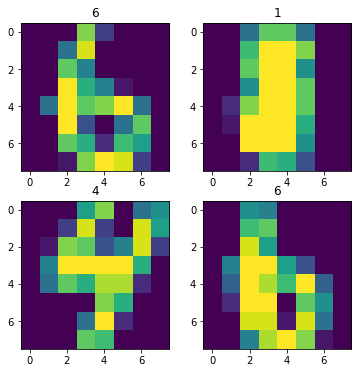

In [4]:
# Visualize the first 4 samples
plt.figure(figsize=(6, 6))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(y[i])
    plt.imshow(X[i].reshape((8, 8)))

plt.show()

As you can see from the above code, our input data has 64 features, each resembling a pixel in each image. We want to reduce the dimensionality of our input using both PCA and t-SNE to visualize all the data points on one chart.

### 1.a) PCA

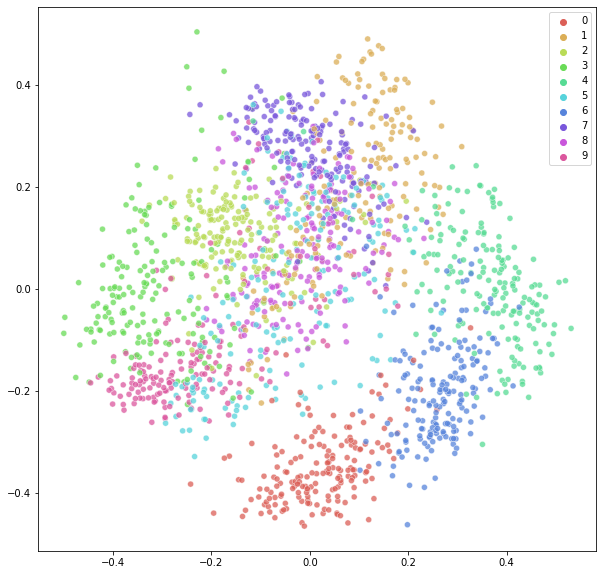

In [5]:
# PCA for X and visualize
X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

### 1.b) t-SNE

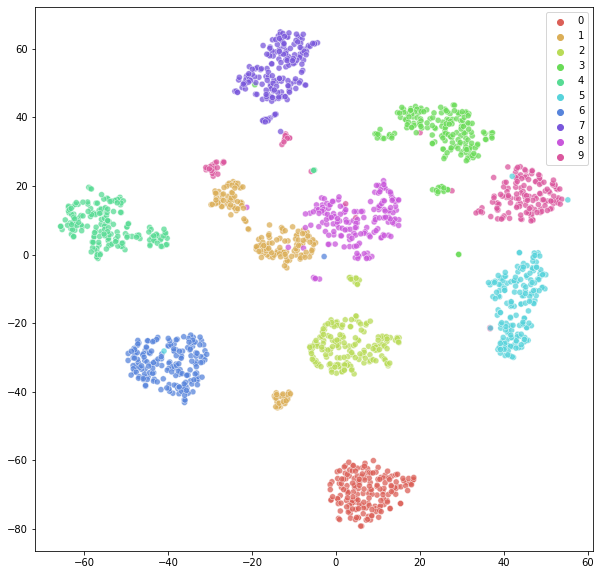

In [6]:
# t-SNE for X and visualize
X_tsne = TSNE(n_components=2, perplexity=25).fit_transform(X)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

## 2. Implementing t-SNE

In this exercise, we follow the implementation of t-SNE directly from the 2008 paper by Maaten and Hinton. It builds upon SNE (Stochastic Neighbor Embedding) and "reduces the tendency to crowd points together in the center
of the map."

#### Intro/Definitions

The goal of t-SNE is to define a location $y_i$ in low-dimension space for high-dimensional points $x_i$. Each point $x_i$ has a probability distribution associated with it of picking another point $x_j$ as its neighbor, defined as $p_{j|i}$ in equation 1 of the paper. $P_i$ is defined as the distribution of other high-dimensional points given $x_i$. Analagously for the low-dimensional points (which we have yet to find), $Q_i$ is defined as the distribution of other low-dimensional points given $y_i$

#### Cost function description

In SNE, the cost function that we're trying to minimize is the "difference" between $P_i$ and $Q_i$ (we want them to be similar). How do we measure difference for probability distributions? The Kullback-Leibler divergence is a measure of dissimilarity between two distributions $P$ and $Q$, defined as $$ \sum_i \left( P(i) \cdot log \frac{P(i)}{Q(i)} \right) $$ for all values $i$ that $P$ and $Q$ take on. You can see how if $P = Q$ for all $i$ (same distribution), the log term will always be $\log 1 = 0$, and so the KLD will be 0 (no dissimilarity). 

As they state in the paper, "In particular, there
is a large cost for using widely separated map points to represent nearby datapoints (i.e., for using a small $q_{j|i}$ to model a large $p_{j|i}$), but there is only a small cost for using nearby map points to
represent widely separated datapoints." You can see that is true - if for some pair of points the $q$ is big and the $p$ is not, the term $$p\cdot log \frac{p}{q}$$ will be small! That will mean that it can mistraslate to low dimension sneakily without seeming like the cost is going up. That is one of the motivations behind t-SNE over SNE.

In [7]:
def Hbeta(D=np.array([]), beta=1.0):
    """
    Compute the perplexity and the P-row for a specific value of the
    precision of a Gaussian distribution.
    
    As we see in the paper, it can be interpreted as a smooth measure of the 
    effective number of neighbors (non-integer).
    """
    # Compute numerator of conditional distributions
    P = np.exp(-D/beta)
    
    # Compute perplexity
    H = np.log(np.sum(P)) + beta * np.sum(D * P) / np.sum(P)
    
    # Normalize P
    P /= np.sum(P)
        
    return H, P

Now we will use the perplexity and conditional probability distributions we have computed, and brute force search for conditional Gaussians that have the same perplexity! (i.e. the $P_i$'s, or the rows of the $n$ by $n$ $P$ matrix)

A way to intuitively think about this is that we should expect any two points to estimate that the "soft" number of neighbors is the same, if they're in the same neighborhood.

In [8]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
    Performs a binary search to get P-values in such a way that each
    conditional Gaussian has the same perplexity.
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))
        
        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        
        H, thisP = Hbeta(Di)
        Hdiff = logU - H
        tries = 0

        while tries < 50 or abs(Hdiff) > tol:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i]*2
                else:
                    beta[i] = (betamin + betamax)/2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i]/2
                else:
                    beta[i] = (betamin + betamax)/2

            H, thisP = Hbeta(Di, beta=beta[i])
            Hdiff = logU - H
            tries += 1

        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [9]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

Now, we will use the Student t-distribution with one degree of freedom to compute Q, the matrix of joint probabiltiies in low dimensions (see equation 4 of the paper).

By the definition of norm squared (as we have discussed in previous assignments, the numerator can be expanded out as $$(1 + y_i^{T} y_i - 2y_i^T y_j + y_j^T y_j)^{-1}$$

In [10]:
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """
    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 400
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4 # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        first_term = np.array([np.linalg.norm(y)**2 for y in Y])
        first_term = np.outer(first_term, np.ones(len(first_term)))

        middle_term = -2*Y.dot(Y.T)
        
        # apply the plus 1 and inverse on your previous value:
        norm_sq = np.add(np.add(middle_term, first_term).T, first_term)
        num = 1. / (1. + norm_sq)
        
        # END OF SUBTASK
        
        # TODO: set the diagonal of numerator to 0, and normalize it to get Q
        # (2 lines)
        np.fill_diagonal(num, 0)
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            # TODO: Implement KL Divergence cost function on P and Q
            p, q = P.flatten(), Q.flatten()
            C = np.sum(p * np.log(p / q))
            # HINT: make sure you wrap it with an np.sum so it's a scalar

            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop exaggerating about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1797...
Computing P-values for point 500 of 1797...
Computing P-values for point 1000 of 1797...
Computing P-values for point 1500 of 1797...
Mean value of sigma: 3.061155
Iteration 10: error is 10.899856
Iteration 20: error is 10.900950
Iteration 30: error is 10.892731
Iteration 40: error is 10.836736
Iteration 50: error is 10.767039
Iteration 60: error is 10.794016
Iteration 70: error is 10.793079
Iteration 80: error is 10.789680
Iteration 90: error is 10.790952
Iteration 100: error is 10.791129
Iteration 110: error is 0.786897
Iteration 120: error is 0.514337
Iteration 130: error is 0.465098
Iteration 140: error is 0.448250
Iteration 150: error is 0.440009
Iteration 160: error is 0.435155
Iteration 170: error is 0.431335
Iteration 180: error is 0.427523
Iteration 190: error is 0.423078
Iteration 200: error is 0.417965
Iteration 210: error is 0.412859
Iteration 220: error is 0.407884

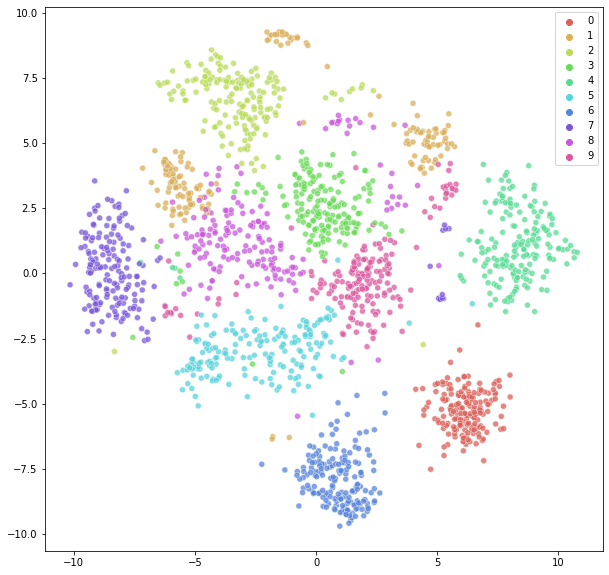

In [11]:
# Run TSNE again to check that the implementation's output matches the library version's output!
X_tsne = tsne(X)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

If your implementation is correct, you should see good separation much like the run in Question 1, though the shapes and locations of the clusters likely won't be the same (due to our implementation and parameters differing slightly from the sklearn t-SNE).

## 3. Conceptual Questions

### 3.a) t-SNE is known to be a 'nonlinear' dimensionality reduction method. As such the distance between points does not accurately reflect distance in the original space. Based on the math behind the technique, explain why t-SNE is nonlinear.

t-SNE is nonlinear because it is mapping a point's neighbors in the high-dimensional space using Gaussian density, and then it models in the lower-dimensional space using Student's t-distribution. Both of these are non-linear models. 

### 3.b) Play around with https://distill.pub/2016/misread-tsne/. Use the square grid example, and find a case where a square is not formed, even after many iterations of the algorithm (>1000 steps).

One such example is this image:

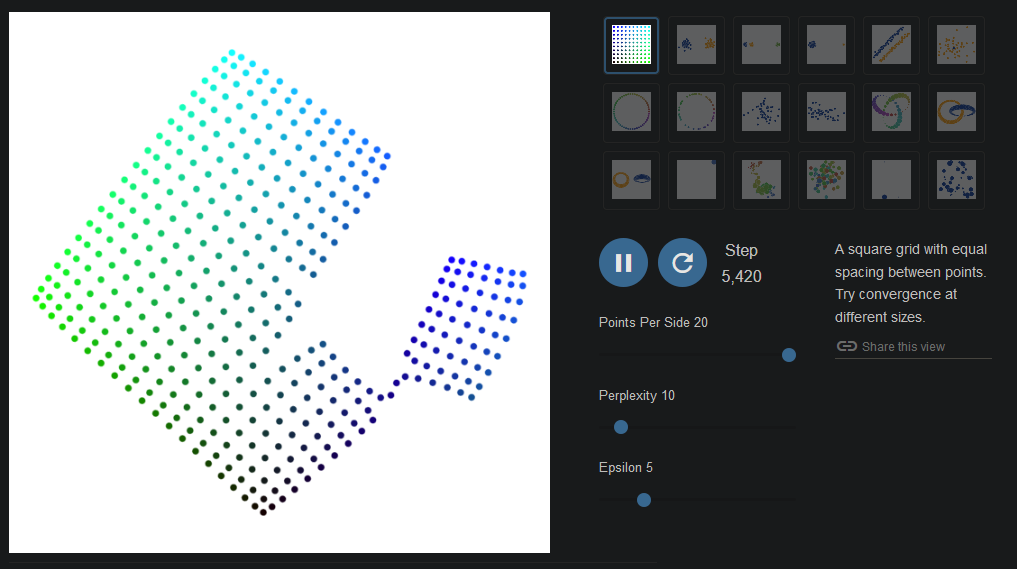

### 3.b) Why might the t-SNE algorithm not be able to form a square grid, even after many steps (greater than 1000)? (hint: has to do with a downside of gradient descent)

Since the objective function for t-SNE is generally non-convex, this means that gradient descent can converge on a poor local minimum, resulting in a low-dimensional map that is not representative of the data. 